In [1]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"valaid","key":"d8f1bba043bc15c08197786acfa3111f"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle competitions download -c bdsc-classification-3-challenge

  0% 0.00/4.14M [00:00<?, ?B/s]
100% 4.14M/4.14M [00:00<00:00, 38.2MB/s]
  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 141MB/s]
 68% 5.00M/7.32M [00:00<00:00, 49.3MB/s]
100% 7.32M/7.32M [00:00<00:00, 46.8MB/s]


In [6]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [7]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [8]:
!ls

id_map.parquet.zip  sample_data  test.csv.zip  train.csv.zip
kaggle.json	    test.csv	 train.csv


In [9]:
!unzip id_map.parquet.zip

Archive:  id_map.parquet.zip
  inflating: id_map.parquet          


In [10]:
!pip install catboost

     |████████████████████████████████| 66.2MB 104kB/s 


In [186]:
import pandas as pd
import numpy as np
import xgboost
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

#Auxilarity Methods

In [193]:
def plot_dist_y_cat(feat, data):
  plt.figure(figsize=(25, 5))
  sns.countplot(x=feat, hue='target', data=data)
  plt.show()

In [12]:
def last_nona(x):
  return x[list_times[x.count()//2-1]]

In [241]:
def check_uniq_wp_targ1(x):
  return len(list(set(x.filter(like='webpage')) & set(lst_wp_targ1)))==0

In [255]:
def check_wp_targ1(lst_wpg, number_wp,list_uniq_wepbages):
  return [1 if wp in list_uniq_wepbages[number_wp-1] else 0 for wp in lst_wpg]

In [43]:
def save_submission(pred):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('notebook_submission.csv')

#Read Data

In [170]:
train = pd.read_csv('train.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

In [171]:
test = pd.read_csv('test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

In [172]:
data_targ1 = train[train.target==1]
data_targ0 = train[train.target==0]

#Data Description

In [167]:
train.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486,2019-02-20 05:57:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,2019-02-22 07:14:51,50150.0,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,2018-12-16 12:35:19,659.0,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,2019-02-13 12:41:05,425.0,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,2018-04-12 06:22:29,451.0,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


Представлены данные по переходам пользователей между страницами. 10 признаков - id страниц на которые осуществлялся переход и 10 признаков - время во время которого был осуществелен переход. Таргет 1 - обозначает пользователя которого необходимо опознать.

In [226]:
list_webpages = ['webpage{}'.format(i) for i in range(1,11)]
list_times = ['time{}'.format(i) for i in range(1,11)]

#EDA + Feature Engineering

Представленные данные нельзя сразу закидывать в модели классфикаторов, хотя бы потому, что данные по времени представлены в формате datetime и он будет принят за категориальную переменную. 

##Target analasys

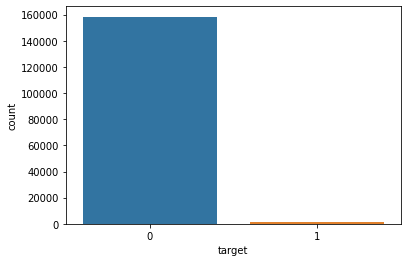

In [175]:
sns.countplot(data=train,x='target')

Видим, что имеется огромнейший дисбаланс данных.

##Difference between first and last time transitions 

Вытащим данные о том сколько времени прошло между переходом на первую и последнюю страницы.

In [176]:
train_ex = train.assign(last_time = lambda x: x.apply(last_nona,axis=1),
                        first_last_diff=lambda x: (x.last_time - x.time1).dt.seconds.fillna(0))

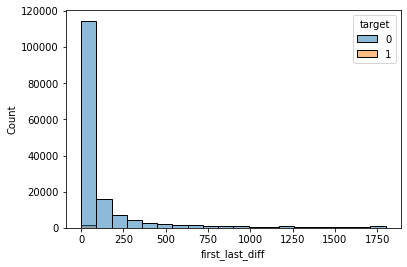

In [181]:
sns.histplot(data=train_ex,x='first_last_diff',hue='target',bins=20)

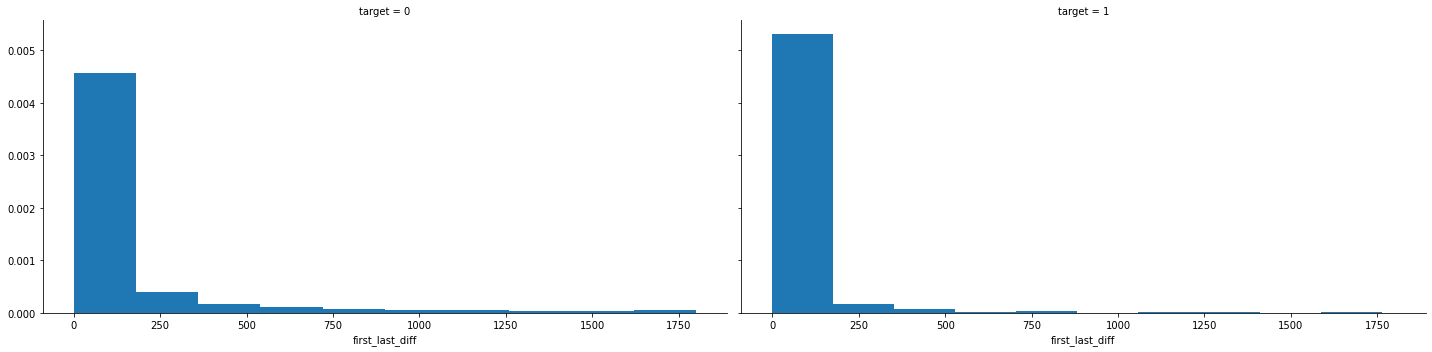

In [187]:
g = sns.FacetGrid(train_ex, col="target", height=5, aspect=2, palette="muted")
g = g.map(plt.hist, "first_last_diff", density=True)

Видим, что имеется различие в графиках, значит данный признак можно взять.

##Day

Вытащим данные о днях недели в которые были собраны данные.

In [192]:
train_ex = train_ex.assign(avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).round())

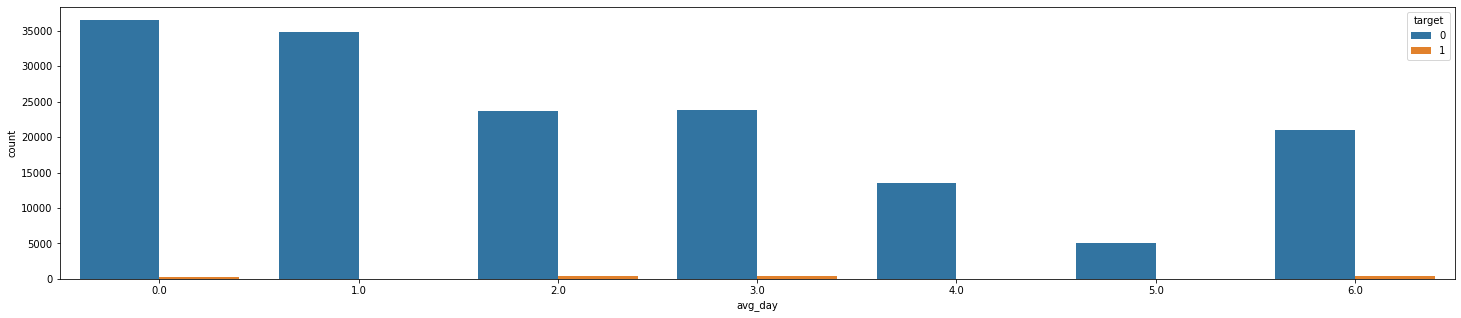

In [195]:
plot_dist_y_cat('avg_day',train_ex)

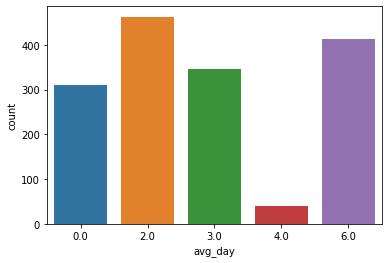

In [199]:
sns.countplot(data=train_ex[train_ex.target==1],x='avg_day')

Видим, существенное различие в выборках. Значит оставляем данный признак.

##Hour

Вытащим данные о времени в которые были осуществелены переходы.

In [202]:
train_ex = train_ex.assign(avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).round())

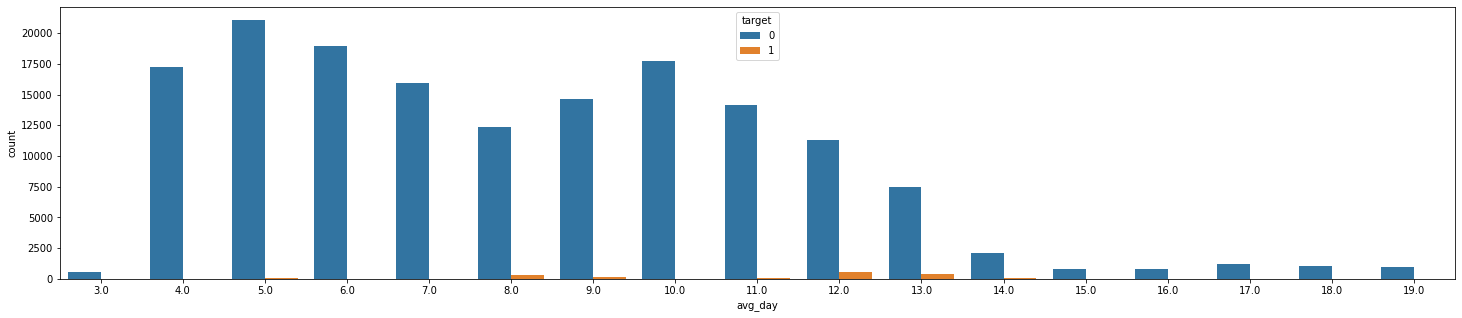

In [203]:
plot_dist_y_cat('avg_hour',train_ex)

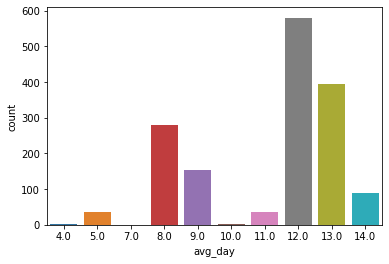

In [204]:
sns.countplot(data=train_ex[train_ex.target==1],x='avg_day')

Видим, существенное различие в выборках. Значит оставляем данный признак.

##N_pages - количество страниц в одной сессии

In [205]:
train_ex = train_ex.assign(n_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.count(), axis=1))

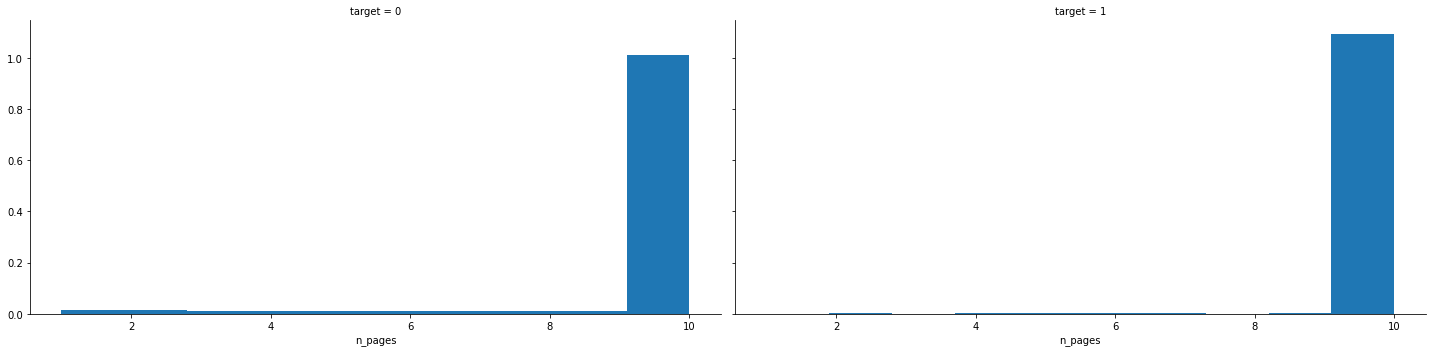

In [206]:
g = sns.FacetGrid(train_ex, col="target", height=5, aspect=2, palette="muted")
g = g.map(plt.hist, "n_pages", density=True)

Существенного различия не видно, значит данный признак не информативен.

##N_unique_pages - количество уникальных страниц в одной сессии

In [207]:
train_ex = train_ex.assign(n__unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1))

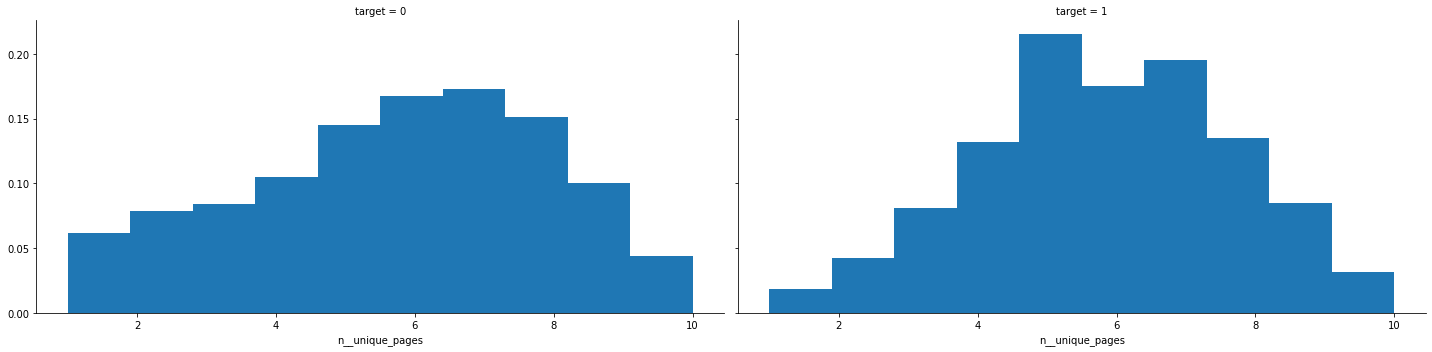

In [208]:
g = sns.FacetGrid(train_ex, col="target", height=5, aspect=2, palette="muted")
g = g.map(plt.hist, "n__unique_pages", density=True)

Различие есть, оставляем данный признак.

#XGBoost

In [169]:
target = train.target
train = train.drop(columns='target')

Попробуем построить модель на собранных данных.

In [227]:
drop_list = list_times.copy()
drop_list.append('last_time')

Признаки день и час переходов, необходимо рассматривать как категориальные, поэтому применим к ним метод get_dummies

In [233]:
def preproc(df,drp_list):
  data = df.assign(
    last_time = lambda x: x.apply(last_nona,axis=1),
    first_last_diff=lambda x: (x.last_time - x.time1).dt.seconds.fillna(0),
    avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).round(),
    avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).round(),
    n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
    ).drop(columns=drop_list).fillna(0.)
  data = pd.get_dummies(data,columns=['avg_day','avg_hour'])
  return data

In [234]:
train_ex=preproc(train,drop_list)

In [235]:
seed = 42
test_size = 0.33
X_train, X_val, y_train, y_val = train_test_split(train_ex.drop(['target'],axis=1), target, test_size=test_size, random_state=seed, stratify=target)

In [237]:
model = xgboost.XGBClassifier(n_estimators=300,scale_pos_weight=1)
model.fit(X_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [238]:
y_pred = model.predict_proba(X_val)

In [239]:
roc_auc_score(y_val,y_pred[:,1])

0.9807562250739504

In [257]:
list_uniq_wepbages = [data_targ1[wp].unique().tolist() for wp in list_webpages]

Получили неплохой результат на валиационном множестве.

Важное примечание: необходимо признаки страниц использовать как категориальные, поскольку просто так, признак будет распознаваться как численный признак, но это не так. 

Предположим что нужный пользователь, всегда заходит на примерно одни и те же страницы. Попробуем улучшить датасет выделив уникальные страницы с таргетом 1 и проверив их наличие в train.

In [243]:
lst_wp_targ1 = pd.concat([data_targ1[wp] for wp in list_webpages]).unique().tolist()
train_ex=train_ex.assign(wp_cont_targ = lambda x: check_uniq_wp_targ1(x))

In [244]:
seed = 42
test_size = 0.33
X_train, X_val, y_train, y_val = train_test_split(train_ex.drop(['target'],axis=1), target, test_size=test_size, random_state=seed, stratify=target)
model = xgboost.XGBClassifier(n_estimators=300,scale_pos_weight=1)
model.fit(X_train, y_train, eval_metric='auc')
y_pred = model.predict_proba(X_val)
roc_auc_score(y_val,y_pred[:,1])

0.9807562250739504

К сожалению, данный признак не внес улучшений. Попробуем теперь проверить наличие страниц на каждом месте соответствующих таргету 1. 

In [246]:
drop_list = drop_list + list_webpages

In [259]:
def preproc_1(df,drop_list):
  data = df.assign(
    last_time = lambda x: x.apply(last_nona,axis=1),
    first_last_diff=lambda x: (x.last_time - x.time1).dt.seconds.fillna(0),
    avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).round(),
    avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).round(),
    n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
    wp1_cont_targ1 = lambda x: check_wp_targ1(x.webpage1,1,list_uniq_wepbages),
    wp2_cont_targ1 = lambda x: check_wp_targ1(x.webpage2,2,list_uniq_wepbages),
    wp3_cont_targ1 = lambda x: check_wp_targ1(x.webpage3,3,list_uniq_wepbages),
    wp4_cont_targ1 = lambda x: check_wp_targ1(x.webpage4,4,list_uniq_wepbages),
    wp5_cont_targ1 = lambda x: check_wp_targ1(x.webpage5,5,list_uniq_wepbages),
    wp6_cont_targ1 = lambda x: check_wp_targ1(x.webpage6,6,list_uniq_wepbages),
    wp7_cont_targ1 = lambda x: check_wp_targ1(x.webpage7,7,list_uniq_wepbages),
    wp8_cont_targ1 = lambda x: check_wp_targ1(x.webpage8,8,list_uniq_wepbages),
    wp9_cont_targ1 = lambda x: check_wp_targ1(x.webpage9,9,list_uniq_wepbages),
    wp10_cont_targ1 = lambda x: check_wp_targ1(x.webpage10,10,list_uniq_wepbages)
    )
  # for i in range(1,10):
  #   data['time_diff_{}'.format(i)] = (data['time{}'.format(i+1)]-data['time{}'.format(i)]).dt.seconds
  data = pd.get_dummies(data,columns=['avg_day','avg_hour'])
  data = data.drop(columns=drop_list).fillna(0)
  return data

In [260]:
train_ex = preproc_1(train,drop_list)

In [261]:
seed = 42
test_size = 0.33
X_train, X_val, y_train, y_val = train_test_split(train_ex.drop(['target'],axis=1), target, test_size=test_size, random_state=seed, stratify=target)
model = xgboost.XGBClassifier(n_estimators=300,scale_pos_weight=1)
model.fit(X_train, y_train, eval_metric='auc')
y_pred = model.predict_proba(X_val)
roc_auc_score(y_val,y_pred[:,1])

0.9964279591175994

In [263]:
test_ex=preproc_1(test,drop_list)

In [ ]:
pred = model.predict_proba(test_ex)[:, 1]
save_submission(pred)
files.download('notebook_submission.csv')

Получили на первый взгляд супер результат. Но после загрузки результата на kaggle получили не настолько хороший результат. Скорее всего из-за новых признаков модель сильно переобучалась, поскольку ограничена набором страниц пользователя train.

#Random Forest

In [ ]:
def preproc(df,drp_list):
  data = df.assign(
    last_time = lambda x: x.apply(last_nona,axis=1),
    first_last_diff=lambda x: (x.last_time - x.time1).dt.seconds.fillna(0),
    avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).round(),
    avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).round(),
    n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
    wp_cont_targ = lambda x: check_uniq_wp_targ1(x)
    ).drop(columns=drop_list).fillna(0.)
  data = pd.get_dummies(data,columns=['avg_day','avg_hour'])
  return data

In [ ]:
train_ex = preproc_1(train,drop_list)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_ex.drop(['target'],axis=1), target, test_size=test_size, random_state=seed, stratify=target)

In [158]:
rfc = RandomForestClassifier(n_estimators=140)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [159]:
y_pred_rfc=rfc.predict_proba(X_val)[:,1]
roc_auc_score(y_val_ex,y_pred_rfc)

0.9793995673352857

In [152]:
pred = model.predict_proba(test_d)[:, 1]
save_submission(pred)
files.download('notebook_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Модель показала результат хуже чем XGB и не дала улучшений в скоре на kaggle.

#CatBoost

CatBoost позволяет использовать в нем категориальные данные напрямую, это его основное преимущество.

In [81]:
def preproc_2(df,drop_list):
  data = df.assign(
    last_time = lambda x: x.apply(last_nona,axis=1),
    first_last_diff=lambda x: (x.last_time - x.time1).dt.seconds.fillna(0),
    avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).round(),
    avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).round(),
    n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
    ).drop(columns=list_times).fillna(0)
  return data

In [ ]:
drop_list = list_times.copy()
drop_list.append('last_time')

In [26]:
train_cat=preproc_2(train,drop_list)
test_d=preproc_2(test,drop_list)

In [28]:
cat_features=list_webpages + ['avg_day','avg_hour']

In [29]:
train_cat[cat_features]=train_cat[cat_features].astype(int)

In [30]:
test_cat[cat_features]=test_cat[cat_features].astype(int)

In [94]:
X_train_ex, X_val_ex, y_train_ex, y_val_ex = train_test_split(train_cat, target, test_size=test_size, random_state=seed, stratify=target)

In [74]:
cat_clf = CatBoostClassifier(random_state=42, verbose=True, eval_metric='AUC')

In [87]:
cat_clf.fit(X_train_cat, y_train_cat, cat_features=cat_features)

Learning rate set to 0.077253
0:	total: 272ms	remaining: 4m 31s
1:	total: 567ms	remaining: 4m 42s
2:	total: 710ms	remaining: 3m 56s
3:	total: 848ms	remaining: 3m 31s
4:	total: 1.01s	remaining: 3m 21s
5:	total: 1.18s	remaining: 3m 16s
6:	total: 1.43s	remaining: 3m 22s
7:	total: 1.57s	remaining: 3m 15s
8:	total: 1.64s	remaining: 3m
9:	total: 1.7s	remaining: 2m 48s
10:	total: 1.9s	remaining: 2m 51s
11:	total: 2.13s	remaining: 2m 55s
12:	total: 2.4s	remaining: 3m 2s
13:	total: 2.58s	remaining: 3m 1s
14:	total: 2.88s	remaining: 3m 8s
15:	total: 3.11s	remaining: 3m 11s
16:	total: 3.48s	remaining: 3m 21s
17:	total: 3.86s	remaining: 3m 30s
18:	total: 4.14s	remaining: 3m 33s
19:	total: 4.48s	remaining: 3m 39s
20:	total: 4.78s	remaining: 3m 43s
21:	total: 5.09s	remaining: 3m 46s
22:	total: 5.31s	remaining: 3m 45s
23:	total: 5.58s	remaining: 3m 46s
24:	total: 5.89s	remaining: 3m 49s
25:	total: 6.04s	remaining: 3m 46s
26:	total: 6.28s	remaining: 3m 46s
27:	total: 6.5s	remaining: 3m 45s
28:	total: 

In [77]:
pred = cat_clf.predict_proba(X_val_cat)
roc_auc_score(y_val_cat,pred[:,1])

0.9930934372972005

In [ ]:
pred = cat_clf.predict_proba(test_cat)[:, 1]
save_submission(pred)
files.download('notebook_submission.csv')

Получили хороший результат, что здесь, что в kaggle. Попробуем его немного улучшить. Добавим разницу во времени между всеми переходами.

In [160]:
def preproc_3(df,drop_list):
  data = df.assign(
    last_time = lambda x: x.apply(last_nona,axis=1),
    first_last_diff=lambda x: (x.last_time - x.time1).dt.seconds.fillna(0),
    avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1).round(),
    avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1).round(),
    n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1),
    )
  for i in range(1,10):
    data['time_diff_{}'.format(i)] = (data['time{}'.format(i+1)]-data['time{}'.format(i)]).dt.seconds
  data = data.drop(columns=drop_list).fillna(0)
  return data

In [ ]:
train_cat=preproc_3(train,drop_list)
test_d=preproc_3(test,drop_list)
train_cat[cat_features]=train_cat[cat_features].astype(int)
test_cat[cat_features]=test_cat[cat_features].astype(int)
X_train_ex, X_val_ex, y_train_ex, y_val_ex = train_test_split(train_cat, target, test_size=test_size, random_state=seed, stratify=target)

In [88]:
pred = cat_clf.predict_proba(X_val_cat)
roc_auc_score(y_val_cat,pred[:,1])

0.9929808950999941

In [89]:
pred = cat_clf.predict_proba(test_cat)[:, 1]
save_submission(pred)
files.download('notebook_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

На валидационной выборке получили ухудшение, но на kaggle получилось небольшое улучшение.

##Hyperparameters tuning

In [32]:
scale_weight = len(target[target==0])/len(target[target==1])
scale_weight

100.56761904761905

In [37]:
grid = {'learning_rate': [0.001,0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations':[500,1000,1500]
        }

In [38]:
cat_clf = CatBoostClassifier(random_state=42, verbose=True, eval_metric='AUC',scale_pos_weight=scale_weight)
grid_search_result = cat_clf.grid_search(grid, X=X_train_cat, y=y_train_cat, 
                                         cv=5,
                                         stratified=True, 
                                         plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9091717769
bestIteration = 499

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9091718	best: 0.9091718 (0)	total: 20.2s	remaining: 45m 8s

bestTest = 0.9667477697
bestIteration = 495

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9667478	best: 0.9667478 (1)	total: 39.9s	remaining: 44m 12s

bestTest = 0.9744559006
bestIteration = 499

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9744559	best: 0.9744559 (2)	total: 59.3s	remaining: 43m 28s

bestTest = 0.9095382572
bestIteration = 494

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9095383	best: 0.9744559 (2)	total: 1m 19s	remaining: 43m 

In [39]:
grid_search_result

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [41]:
cat_clf = CatBoostClassifier(random_state=42, verbose=True, eval_metric='AUC',scale_pos_weight=scale_weight, iterations=1500, l2_leaf_reg=7,depth=6,learning_rate=0.03)
cat_clf.fit(X_train_cat, y_train_cat, cat_features=cat_features)

0:	total: 244ms	remaining: 6m 5s
1:	total: 339ms	remaining: 4m 13s
2:	total: 711ms	remaining: 5m 54s
3:	total: 1.01s	remaining: 6m 17s
4:	total: 1.26s	remaining: 6m 18s
5:	total: 1.51s	remaining: 6m 17s
6:	total: 1.74s	remaining: 6m 11s
7:	total: 2.06s	remaining: 6m 25s
8:	total: 2.22s	remaining: 6m 7s
9:	total: 2.38s	remaining: 5m 55s
10:	total: 2.55s	remaining: 5m 44s
11:	total: 2.88s	remaining: 5m 56s
12:	total: 3.07s	remaining: 5m 51s
13:	total: 3.35s	remaining: 5m 55s
14:	total: 3.56s	remaining: 5m 52s
15:	total: 3.75s	remaining: 5m 47s
16:	total: 4.01s	remaining: 5m 50s
17:	total: 4.27s	remaining: 5m 51s
18:	total: 4.61s	remaining: 5m 59s
19:	total: 4.85s	remaining: 5m 58s
20:	total: 5.18s	remaining: 6m 4s
21:	total: 5.49s	remaining: 6m 8s
22:	total: 5.86s	remaining: 6m 16s
23:	total: 6.1s	remaining: 6m 15s
24:	total: 6.5s	remaining: 6m 23s
25:	total: 6.82s	remaining: 6m 26s
26:	total: 7.07s	remaining: 6m 25s
27:	total: 7.39s	remaining: 6m 28s
28:	total: 7.71s	remaining: 6m 31s
2

In [42]:
pred = cat_clf.predict_proba(X_val_cat)[:,1]
roc_auc_score(y_val_cat,pred)

0.9926920316031125

In [44]:
pred = cat_clf.predict_proba(test_cat)[:, 1]
save_submission(pred)
files.download('notebook_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

На валидации не получилось улучшений, но на kaggle удалось добиться лучшего результата.

Посмотрим на feature importance.

In [90]:
cat_clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,avg_hour,26.032886
1,avg_day,21.072490
2,first_last_diff,4.500719
3,webpage8,3.972724
4,webpage6,3.817595
5,n_unique_pages,3.641572
6,webpage5,3.618952
7,webpage1,3.497583
8,webpage7,3.416249
9,webpage4,3.200318


Самыми информативными получились признаки дня и часа, а разницы во времени между переходами дает намного меньше информации.

P.S. пару слов о том что почти ничего не сделано с имбалансом.


Несмотря на то, что в данных присутствует огромный имбаланс, мы почти ничего с этим не делаем  поскольку используем алгоритмы с деревьями, которые не восприимчивы к имбалансу. И изменение параметров в модели относящихся к преодолению имбаланса (в частности 'scale_pos_weight') ничего не давало (не отражено здесь к сожалению).